# Stage 1 - Lesson 4: XGBoost Implementation

This notebook implements an XGBoost model for time series prediction using the engineered features from Lesson 3. We will:
1. Load and prepare the processed data
2. Set up train/validation/test splits
3. Implement XGBoost with initial parameters
4. Perform hyperparameter tuning
5. Train the final model

In [13]:
# Import required libraries
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
from sklearn.preprocessing import StandardScaler

# Set random seed for reproducibility
np.random.seed(42)

## 1. Data Loading and Preparation

In [14]:
# Load the processed data
def load_data():
    df = pd.read_csv('../../data/processed_features.csv')
    df['Date'] = pd.to_datetime(df['Date'])
    return df

# Load data
df = load_data()
print("Data shape:", df.shape)
df.head()

Data shape: (892, 305)


,Date,Adj Close,Volume,Volume_lag_1,Volume_lag_2,Volume_lag_3,Volume_lag_4,Volume_lag_5,Volume_lag_6,Volume_lag_7,...,Volume_lag_293,Volume_lag_294,Volume_lag_295,Volume_lag_296,Volume_lag_297,Volume_lag_298,Volume_lag_299,Volume_lag_300,Volume_rolling_mean_3,target
0,2021-06-16 00:00:00+00:00,120.980934,21562000.0,22098000.0,21958000.0,25904000.0,17942000.0,24240000.0,24120000.0,24458000.0,...,57896000.0,42236000.0,63358000.0,38702000.0,54028000.0,40334000.0,61620000.0,63320000.0,2.332000e+07,120.772499
1,2021-06-17 00:00:00+00:00,120.336266,26472000.0,21562000.0,22098000.0,21958000.0,25904000.0,17942000.0,24240000.0,24120000.0,...,51050000.0,57896000.0,42236000.0,63358000.0,38702000.0,54028000.0,40334000.0,61620000.0,2.187267e+07,121.743500
2,2021-06-18 00:00:00+00:00,121.303764,25842000.0,26472000.0,21562000.0,22098000.0,21958000.0,25904000.0,17942000.0,24240000.0,...,35292000.0,51050000.0,57896000.0,42236000.0,63358000.0,38702000.0,54028000.0,40334000.0,2.337733e+07,120.111000
3,2021-06-21 00:00:00+00:00,119.677162,46116000.0,25842000.0,26472000.0,21562000.0,22098000.0,21958000.0,25904000.0,17942000.0,...,49648000.0,35292000.0,51050000.0,57896000.0,42236000.0,63358000.0,38702000.0,54028000.0,2.462533e+07,121.812500
4,2021-06-22 00:00:00+00:00,121.372513,27414000.0,46116000.0,25842000.0,26472000.0,21562000.0,22098000.0,21958000.0,25904000.0,...,46296000.0,49648000.0,35292000.0,51050000.0,57896000.0,42236000.0,63358000.0,38702000.0,3.281000e+07,122.330498


## 2. Train/Validation/Test Split

We implement a time-series-aware data splitting strategy. 

**Unlike traditional random splitting**, we maintain temporal order.

For time series data, we need to maintain temporal order in our splits:
- Training set: Uses the oldest 70% of the data
- Validation set: Uses the next 15% of data
- Test set: Uses the most recent 15% of data
We also standardize our features using StandardScaler to ensure all features are on the same scale, which is important for XGBoost performance.

In [15]:
def prepare_data_splits(df):
    # Sort by date
    df = df.sort_values('Date')
    
    # Separate features and target
    X = df.drop(['Date', 'target'], axis=1)
    y = df['target']
    
    # Calculate split indices
    train_size = int(len(df) * 0.9)
    
    # Split the data
    X_train = X[:train_size]
    y_train = y[:train_size]
    
    X_test = X[train_size:]
    y_test = y[train_size:]

    return (X_train, y_train, X_test, y_test)

# Prepare data splits
# (X_train_scaled, y_train, X_val_scaled, y_val, 
#  X_test_scaled, y_test, scaler) = prepare_data_splits(df)
(X_train, y_train, 
 X_test, y_test) = prepare_data_splits(df)

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

Training set size: (802, 303)
Test set size: (90, 303)


## 3. Initial XGBoost Model

This section implements the first version of our XGBoost model with baseline parameters:

- Sets up a basic XGBoost regressor with common default parameters

- Uses squared error as the objective function

- Implements early stopping to prevent overfitting

- Includes initial hyperparameters like max_depth=6, learning_rate=0.1

- This gives us a baseline model to improve upon through tuning.

In [16]:
def train_initial_model():
    # Initial parameters
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'max_depth': 9,
        'learning_rate': 0.2,
        'n_estimators': 100,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'random_state': 42
    }
    
    # Create and train model
    model = xgb.XGBRegressor(**params)
    model.fit(
        X_train, y_train,
    )
    
    return model

# Train initial model
initial_model = train_initial_model()

## 4. Hyperparameter Tuning

Here we perform systematic hyperparameter optimization:

- Uses RandomizedSearchCV for efficient parameter search
- Tunes key parameters like max_depth, learning_rate, n_estimators
- Implements time series cross-validation to maintain temporal order
- Tests multiple combinations of parameters to find the optimal set
- This helps us find the best model configuration for our specific prediction task.

In [22]:
from sklearn.model_selection import RandomizedSearchCV

def tune_hyperparameters():
    param_dist = {
        'max_depth': [1,2,3],
        'learning_rate': [0.01, 0.05,0.1],
        'n_estimators': [10,20,30],
        'subsample': [0.3,0.4,0.5,0.6,.7,.8,.9],
        'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
        'min_child_weight': [10,20,30],
        'gamma': [.3,0.4,.5,.6,.7]
    }
    
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror')
    
    # Time series split for cross-validation
    tscv = TimeSeriesSplit(n_splits=5)
    
    # Random search
    random_search = RandomizedSearchCV(
        xgb_model, param_dist, n_iter=50,
        scoring='neg_mean_squared_error',
        cv=tscv, n_jobs=-1, random_state=42
    )
    
    # Fit random search
    random_search.fit(X_train, y_train)
    
    print("Best parameters:", random_search.best_params_)
    print("Best RMSE:", (-random_search.best_score_)**0.5)
    
    return random_search.best_estimator_

# Tune hyperparameters
tuned_model = tune_hyperparameters()

Best parameters: {'subsample': 0.5, 'n_estimators': 30, 'min_child_weight': 20, 'max_depth': 2, 'learning_rate': 0.1, 'gamma': 0.6, 'colsample_bytree': 0.8}
Best RMSE: 15.070225526155806


## 5. Model Evaluation

This section focuses on comprehensive model assessment:

- Evaluates model performance on training, validation, and test sets
- Calculates key metrics: RMSE (Root Mean Square Error), MAE (Mean Absolute Error), R² score
- Helps understand model generalization and potential overfitting
- Provides insights into prediction accuracy across different time periods

In [23]:
def evaluate_model(model, X, y, set_name):
    # Make predictions
    predictions = model.predict(X)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y, predictions))
    mae = mean_absolute_error(y, predictions)
    r2 = r2_score(y, predictions)
    
    print(f"\n{set_name} Metrics:")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R2 Score: {r2:.4f}")
    
    return predictions

# Evaluate on all sets
train_preds = evaluate_model(tuned_model, X_train, y_train, "Training")
test_preds = evaluate_model(tuned_model, X_test, y_test, "Test")


Training Metrics:
RMSE: 3.55
MAE: 2.69
R2 Score: 0.9763

Test Metrics:
RMSE: 8.99
MAE: 6.61
R2 Score: 0.4202


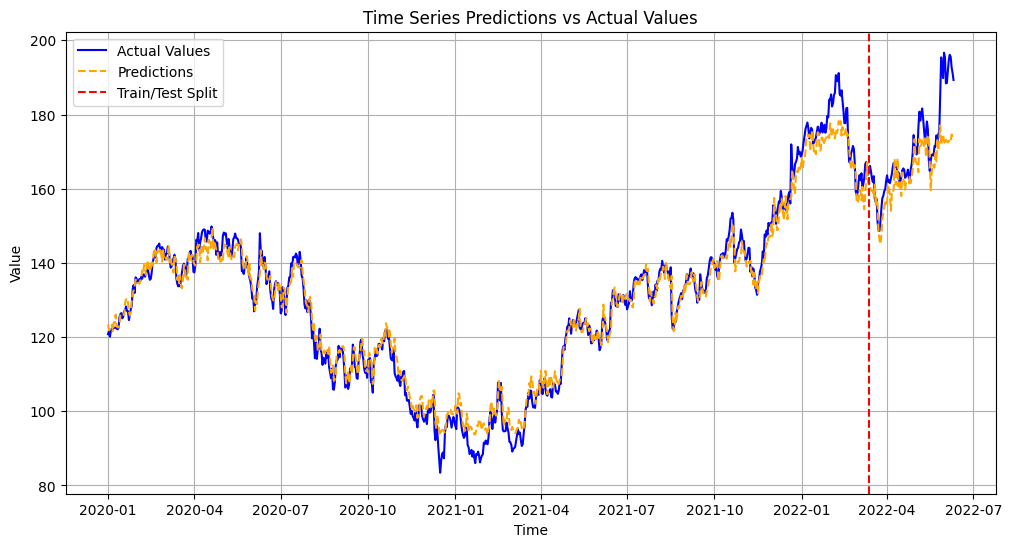

In [24]:

actual_values = pd.concat([y_train,y_test])

# Concatenate the predictions
predictions = np.concatenate([train_preds,test_preds])

# Create a time index (if not already available)
time_index = pd.date_range(start="2020-01-01", periods=len(actual_values), freq="D")  # Example: daily frequency

# Plot the actual values and predictions
plt.figure(figsize=(12, 6))
plt.plot(time_index, actual_values, label="Actual Values", color="blue")
plt.plot(time_index, predictions, label="Predictions", color="orange", linestyle="--")

# # Add vertical lines to separate training, validation, and test sets
train_end = len(y_train)
plt.axvline(time_index[train_end], color="red", linestyle="--", label="Train/Test Split")

# Add labels, title, and legend
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Time Series Predictions vs Actual Values")
plt.legend()
plt.grid()
plt.show()

## 6. Feature Importance Analysis

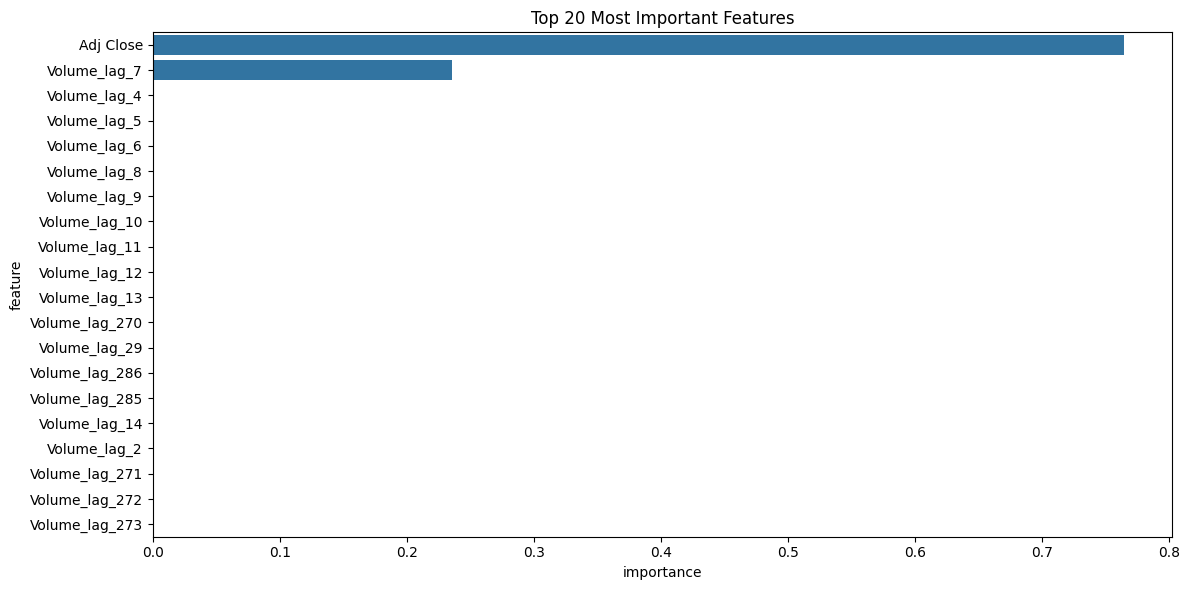

In [20]:
def plot_feature_importance(model, feature_names):
    # Get feature importance
    importance = model.feature_importances_
    
    # Create DataFrame of features and importance
    feat_imp = pd.DataFrame({
        'feature': feature_names,
        'importance': importance
    })
    
    # Sort by importance
    feat_imp = feat_imp.sort_values('importance', ascending=False)
    
    # Plot
    plt.figure(figsize=(12, 6))
    sns.barplot(x='importance', y='feature', data=feat_imp.head(20))
    plt.title('Top 20 Most Important Features')
    plt.tight_layout()
    plt.show()

# Plot feature importance
feature_names = df.drop(['Date', 'target'], axis=1).columns
plot_feature_importance(tuned_model, feature_names)

## 7. Save Model

In [21]:
# Save model and scaler
import joblib

model_path = '../../models/xgboost_model_init.joblib'

joblib.dump(tuned_model, model_path)

print("Model and scaler saved successfully!")

Model and scaler saved successfully!
